# Applied Machine Learning Systems ELEC0134 (19/20) Assignment

## Table of Contents:

0. Setting Up Environment
1. Exploratory Data Analysis
2. TASK A1: Gender Detection (Male/Female)

## 0. Setting Up Environment

Please set this variable to FALSE if you wanted to retrain the model  

In [1]:
! pip3 install -r requirements.txt

Some general constants that will be used in the code:

In [16]:
import csv
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import pickle

from collections import Counter
from imutils import face_utils
from PIL import Image
from skimage import color, feature, io
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from tqdm import tqdm


TEST_DATASET_SIZE_PROPORTION = 0.2
K_CROSSVAL = 2
CSV_LABEL_SEPARATOR_MARK = '\t'

# TASK A
TASK_A_DATASET_DIR = 'Datasets/celeba/img/'
TASK_A_LABEL_CSV_FILEPATH = 'Datasets/celeba/labels.csv'
TASK_A_X_HEADER_NAME = 'img_name'
TASK_A1_Y_HEADER_NAME = 'gender'
TASK_A2_Y_HEADER_NAME = 'smiling'
TASK_A1_FACE_OUTPUT_DIR  = 'Datasets/processed/celeba_cropped_face/' 
TASK_A2_MOUTH_OUTPUT_DIR = 'Datasets/processed/celeba_cropped_mouth/'

# TASK B
TASK_B_DATASET_DIR = 'Datasets/cartoon_set/img/'
TASK_B_LABEL_CSV_FILEPATH = 'Datasets/cartoon_set/labels.csv'
TASK_B_X_HEADER_NAME = 'file_name'
TASK_B1_Y_HEADER_NAME = 'face_shape'
TASK_B2_Y_HEADER_NAME = 'eye_color'

## 1. Exploratory Data Analysis

Firstly, let's take a look at characteristics of our dataset. We'll look at the proportion of each label in our dataset, the pixel dimension of image datasets, and to see if whether we should do some additional preprocessing.

### 1.1. Proportion of Label

#### 1.1.1. Task A1: Gender Detection using Celeba Dataset

In [2]:
task_a_label_df = pd.read_csv(
                    TASK_A_LABEL_CSV_FILEPATH,
                    sep=CSV_LABEL_SEPARATOR_MARK
                )
print(task_a_label_df[TASK_A1_Y_HEADER_NAME].value_counts())
print(task_a_label_df.hist(column=TASK_A1_Y_HEADER_NAME))

-1    2500
 1    2500
Name: gender, dtype: int64
[[<matplotlib.axes._subplots.AxesSubplot object at 0x1248fe3d0>]]


***
#### 1.1.2. Task A2: Emotion Detection (smiling or not) using Celeba Dataset

-1    2500
 1    2500
Name: smiling, dtype: int64
[[<matplotlib.axes._subplots.AxesSubplot object at 0x108a4cc90>]]


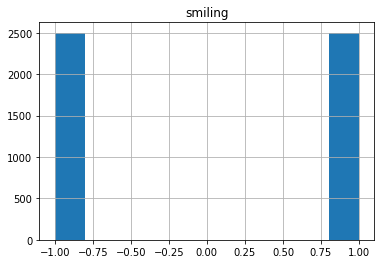

In [3]:
print(task_a_label_df[TASK_A2_Y_HEADER_NAME].value_counts())
print(task_a_label_df.hist(column=TASK_A2_Y_HEADER_NAME))

***
#### 1.1.3. Task B1: Face Shape Recognition using Cartoonset Dataset

4    2000
3    2000
2    2000
1    2000
0    2000
Name: face_shape, dtype: int64
[[<matplotlib.axes._subplots.AxesSubplot object at 0x124f67a50>]]


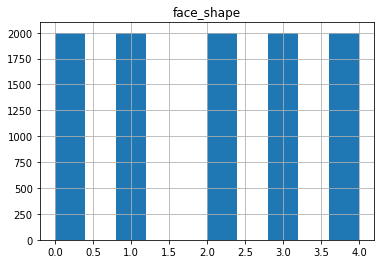

In [7]:
task_b_label_df = pd.read_csv(
                    TASK_B_LABEL_CSV_FILEPATH,
                    sep=CSV_LABEL_SEPARATOR_MARK
                )
print(task_b_label_df[TASK_B1_Y_HEADER_NAME].value_counts())
print(task_b_label_df.hist(column=TASK_B1_Y_HEADER_NAME))

***
#### 1.1.4. Task B2: Eye Colour Recognition using Cartoonset Dataset

1    2018
4    2017
0    2004
3    1992
2    1969
Name: eye_color, dtype: int64
[[<matplotlib.axes._subplots.AxesSubplot object at 0x125714c90>]]


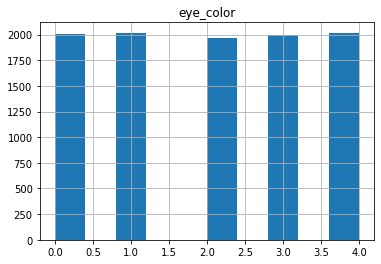

In [8]:
print(task_b_label_df[TASK_B2_Y_HEADER_NAME].value_counts())
print(task_b_label_df.hist(column=TASK_B2_Y_HEADER_NAME))

***
Now, let's look at the dimension of each image in our two datasets, to see if whether we should do preprocessing to make the image size uniform.

### 1.2. Pixel Dimension of Image Dataset

#### 1.2.1. Task A Dataset

In [17]:
def check_pixel_size_in_dataset(dataset_foldername, filename_list):
    pixel_size_list = []
    for filename in filename_list:
        filepath = os.path.join(dataset_foldername, filename)
        width, height = Image.open(filepath).size
        pixel_size_list.append(str(width) + ", " + str(height))
    pixel_size_df = pd.DataFrame(pixel_size_list, columns=['img_dimension'])
    print(pixel_size_df['img_dimension'].value_counts())
    return pixel_size_df['img_dimension'].value_counts(), pixel_size_df['img_dimension'].hist()

178, 218    5000
Name: img_dimension, dtype: int64


(178, 218    5000
 Name: img_dimension, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x125998550>)

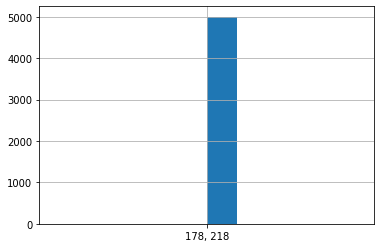

In [18]:
task_a_img_filename_list = task_a_label_df[TASK_A_X_HEADER_NAME]
check_pixel_size_in_dataset(TASK_A_DATASET_DIR, task_a_img_filename_list)

#### 1.2.2. Task B Dataset

500, 500    10000
Name: img_dimension, dtype: int64


(500, 500    10000
 Name: img_dimension, dtype: int64,
 <matplotlib.axes._subplots.AxesSubplot at 0x125971b10>)

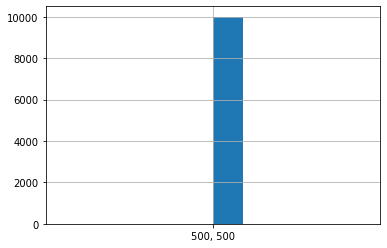

In [9]:
task_b_img_filename_list = task_b_label_df[TASK_B_X_HEADER_NAME]
check_pixel_size_in_dataset(TASK_B_DATASET_DIR, task_b_img_filename_list)

***
### 1.3. Conclusion from Exploratory Data Analysis
From the exploratory data analysis, we learn that the ratio/proportion of each label in dataset is already good, so we don't need to preprocess the dataset to even out the ratio.

***

## 2. TASK A1: Gender Detection (Male/Female)

In this binary classification task, we are going to use the `celeba` dataset to detect gender from the face image dataset.

### 2.1. Load the Dataset

Firstly we wanted to load the dataset. Separating training and testing dataset will be done in later process.


In [19]:
def determine_X_and_Y_set_from_label_file(label_csv_filepath, x_header_name, y_header_name, delimiter=CSV_LABEL_SEPARATOR_MARK):
    """Determine the X (the input features) and the Y (label) from a CSV file
    """
    X = []
    Y = []
    with open(label_csv_filepath) as csv_file:
        data = csv.DictReader(csv_file, delimiter=delimiter)
        for row in data:
            X.append(row[x_header_name])
            Y.append(row[y_header_name])
    return X, Y

In [20]:
X, Y = determine_X_and_Y_set_from_label_file(
    TASK_A_LABEL_CSV_FILEPATH,
    TASK_A_X_HEADER_NAME,
    TASK_A1_Y_HEADER_NAME
)

### 2.2. Cropping the Person's Face from the Image

In [23]:
def hog_face_detector(input_dir, img_filename, face_detector, output_dir):
    """Detect face using HOG
    """
    img_filepath = os.path.join(input_dir, img_filename)
    img = cv2.imread(img_filepath)
    
    rects = face_detector(img, 1)
    for (i, rect) in enumerate(rects):
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cropped_img = img[
            y:y+h,
            x:x+w,
        ]

        cv2.imwrite(os.path.join(output_dir, img_filename), cropped_img)

In [24]:
face_detector = dlib.get_frontal_face_detector()

for X_filename in tqdm(X):
    hog_face_detector(
        input_dir = TASK_A_DATASET_DIR,
        img_filename = X_filename,
        face_detector = face_detector,
        output_dir = TASK_A1_FACE_OUTPUT_DIR,
    )

100%|██████████| 5000/5000 [01:57<00:00, 42.44it/s]


### 2.3. Divide into Training and Testing Dataset¶

There will be some images where the mouth is undetected. In this case, we are unable to use that particular image.
After deciding which of data can be used, we are then going to divide the dataset into either training or testing set.

In [27]:
cropped_img_filenames = os.listdir(TASK_A1_FACE_OUTPUT_DIR)

X_cropped = []
Y_cropped = []
for ori_img_filename in X:
    if ori_img_filename in cropped_img_filenames:
        X_cropped.append(ori_img_filename)
        row_num = X.index(ori_img_filename)
        Y_cropped.append(Y[row_num])

X_train_filenames, X_test_filenames, Y_train, Y_test = train_test_split(
    X_cropped, Y_cropped, test_size=TEST_DATASET_SIZE_PROPORTION, random_state=42,
)

print("training data : ", len(X_train_filenames))
print("testing data  : ", len(X_test_filenames))

training data :  3864
testing data  :  967


### 2.4. Local Binary Pattern (LBP) + Histogram

As part of the feature engineering, we are going to convert raw images into greyscale. The next process is to determine the LBP. After that, the final step is to output the resulted histogram. This (standardised, which will be done later) histogram is going to be the feature that will be used to be fitted into training process.

In [28]:
def convert_raw_images_to_lbp_histograms(image_dir, image_filenames, lbp_params):
    """Extract LBP histograms from raw images 
    """
    hists = []
    for filename in tqdm(image_filenames):
        filepath = os.path.join(image_dir, filename)

        # load the image file
        image = io.imread(filepath)

        # convert RGB image into greyscale
        grey_image = color.rgb2grey(image)

        # convert greyscale image into lbp features
        lbp_image = feature.local_binary_pattern(
            grey_image,
            lbp_params['n_points'],
            lbp_params['radius'],
            lbp_params['method'],
        )

        # convert lbp features into histogram
        n_bins = int(lbp_image.max() + 1)
        hist, _ = np.histogram(
            lbp_image.ravel(),
            bins=n_bins,
            range=(0, n_bins)
        )
        hists.append(hist)
    return hists

In [29]:
LBP_PARAMS = {
    'n_points': 8,
    'radius'  : 1,
    'method'  : 'default',
#     'method'  : 'uniform',
#     'method'  : 'ror',
}
    
X_train_hists = convert_raw_images_to_lbp_histograms(
    TASK_A1_FACE_OUTPUT_DIR,
    X_train_filenames,
    LBP_PARAMS,
)


100%|██████████| 3864/3864 [00:13<00:00, 286.11it/s]


### 2.5. SVM Classifier Parameter Tuning
The next thing to do is to use the histogram features and fit it into an SVM classifier.<br>
We are going to use grid search and k-fold cross validation, which is `GridSearchCV` function in Scikit Learn

In [32]:
# if local model exists, use them instead of retraining it
# otherwise, train the SVM model with gridsearch+k-fold CV
try:
    TASK_A1_MODELS_PKL_FILEPATH = 'models/task_a1_dec_15_v2.pkl'
    clf = pickle.load(
        open(TASK_A1_MODELS_PKL_FILEPATH, "rb")
    )
    print("local model is found and being used instead of retraining the model")
except (OSError, IOError) as e:
    print("training SVM (and save the resulted model afterwards to a local pickle file)")
    # SVM hyperparameter tuning
#     svm_param_candidates = [
# #         {
# #             'kernel': ['rbf'],
# #             'gamma' : [1e-3, 1e-4],
# #     #         'C'     : [1],
# #             'C'     : [1, 10, 100, 1000]
# #         },
#         {
#             'kernel': ['linear'],
#             'C'     : [1],
# #             'C'     : [1, 10, 100, 1000]
#         }
#     ]
    svm_param_candidates = [
        {
            'C'     : [1, 10, 100],
        },
    ]


    # Do grid search and k-cross validation to SVM Classifier
    
    clf = make_pipeline(
        StandardScaler(),
        GridSearchCV(
            LinearSVC(max_iter=1000000),
#             SVC(),
            svm_param_candidates,
            cv = K_CROSSVAL,
            iid = False, # suggested value from sklearn
            n_jobs = -1,
            verbose = 4,
        ),
    )
#     clf = GridSearchCV(
# #         LinearSVC(),
#         SVC(),
#         svm_param_candidates,
#         cv = K_CROSSVAL,
#         iid = False, # suggested value from sklearn
#         n_jobs = -1,
#         verbose = 4,
#     )
#     from sklearn.svm import LinearSVC
#     clf = LinearSVC(random_state=0, tol=1e-5, C=10, verbose=True, max_iter=10000)
#     from sklearn import preprocessing
    # # buang
#     X_train_hists = X_train_hists[:250]
#     Y_train = Y_train[:250]
    clf.fit(X_train_hists, Y_train)
    
    # save all the models resulted to a local pickle
    pickle.dump(
        clf,
        open(TASK_A1_MODELS_PKL_FILEPATH, "wb")
    )

training SVM (and save the resulted model afterwards to a local pickle file)
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  7.6min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 20.8min finished
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [33]:
# Best parameters and best result on development set
print('best params : ', clf.best_params_)
print('mean        : ', clf.cv_results_['mean_test_score'])
print('stdev       : ', clf.cv_results_['std_test_score'])
print('params      : ', clf.cv_results_['params'])
print('best estimator: ', clf.best_estimator_)

print(clf)

AttributeError: 'Pipeline' object has no attribute 'best_params_'

### 2.6. Inference

Now that the training process is done and we have the model, we will see the accuracy score of this selected model by using testing dataset that the model has never seen before.

In [35]:
X_test_hists = convert_raw_images_to_lbp_histograms(
    TASK_A1_FACE_OUTPUT_DIR,
    X_test_filenames,
    LBP_PARAMS,
)


Y_pred = clf.predict(X_test_hists)
print("acc score ", accuracy_score(Y_test, Y_pred))

100%|██████████| 967/967 [00:03<00:00, 287.31it/s]

acc score  0.766287487073423


## 3. TASK A2: Emotion Detection (Smiling/Not Smiling)

In this binary classification task, we are going to use the `celeba` dataset again to detect whether the person on the photo is smiling or not

### 3.1. Load the Dataset

Firstly we wanted to load the dataset. Separating training and testing dataset will be done in later process.

In [38]:
X, Y = determine_X_and_Y_set_from_label_file(
    TASK_A_LABEL_CSV_FILEPATH,
    TASK_A_X_HEADER_NAME,
    TASK_A2_Y_HEADER_NAME
)

### 3.2. Cropping the Person's Lip from the Image

We are going to crop the lip/mouth from the image, using the Haar Cascade. The cropped image will be saved in a dedicated folder.

In [ ]:
$$$WAIT, coba pikirin ulang tentang reusing pickle filenya, soalnya
kan ntar jadi ada data testing yg muncul lagi (karena train/test splitting)

harus ditulis bahwa for the purpose of presentation alias
feasibility to present the result in short time (without having to wait
        hours and hours, we're going to use pickle and train/test split yg ga random)

In [17]:
def haar_cascade_object_cropping(input_dir, img_filename, haar_cascade_filepath, scale_factor, min_neighbors, output_dir):
    """Detect object that matters using Haar Cascade, crop the image, then save the cropped image to a local folder
    """
    img_filepath = os.path.join(input_dir, img_filename)
    right_eye_cascade = cv2.CascadeClassifier(haar_cascade_filepath)
    img = cv2.imread(img_filepath)
#     $$$# https://stackoverflow.com/questions/20801015/recommended-values-for-opencv-detectmultiscale-parameters
    obj = right_eye_cascade.detectMultiScale(img, scale_factor, min_neighbors)
    for (x, y, w, h) in obj:
        cropped_img = img[y:y+h, x:x+w]
        cropped_img = cv2.resize(cropped_img, dsize=(42, 26))
#         cropped_img = cropped_img.resize((42,26), Image.ANTIALIAS)
        cv2.imwrite(os.path.join(output_dir, img_filename), cropped_img)

In [18]:
# haarcascade_mouth_filepath = 'haarcascades/haarcascade_mcs_mouth.xml'

# scale_factor = 1.7
# min_neighbors = 3

# for X_filename in tqdm(X):
#     haar_cascade_object_cropping(
#         input_dir = TASK_A_DATASET_DIR,
#         img_filename = X_filename,
#         haar_cascade_filepath = haarcascade_mouth_filepath,
#         scale_factor = scale_factor,
#         min_neighbors = min_neighbors,
#         output_dir = TASK_A2_MOUTH_OUTPUT_DIR,
#     )

100%|██████████| 5000/5000 [01:41<00:00, 49.44it/s]


In [8]:
def hog_mouth_detector(input_dir, img_filename, face_detector, shape_predictor, output_dir):
    """Detect mouth using HOG
    """  
    # https://www.pyimagesearch.com/2017/04/10/detect-eyes-nose-lips-jaw-dlib-opencv-python/
    mouth_point_start = 48
    mouth_point_end = 68
    
    img_filepath = os.path.join(input_dir, img_filename)
    img = cv2.imread(img_filepath)
    
    rects = face_detector(img, 1)
    for (i, rect) in enumerate(rects):
        shape = shape_predictor(img, rect)
        
        mouth_x_points = [shape.part(nth_point).x for nth_point in range(mouth_point_start, mouth_point_end)]
        mouth_y_points = [shape.part(nth_point).y for nth_point in range(mouth_point_start, mouth_point_end)]

        max_x = max(mouth_x_points)
        min_x = min(mouth_x_points)
        max_y = max(mouth_y_points)
        min_y = min(mouth_y_points)
        extra = 3

        cropped_img = img[
                min_y - extra:max_y + extra,
                min_x - extra:max_x + extra,
        ]

#         cropped_img = cv2.resize(cropped_img, dsize=(42, 26))
#         cropped_img = cropped_img.resize((42,26), Image.ANTIALIAS)
        cv2.imwrite(os.path.join(output_dir, img_filename), cropped_img)


In [13]:
face_detector = dlib.get_frontal_face_detector()

SHAPE_PREDICTOR_68_FACE_LANDMARKS_FILEPATH = "models/shape_predictor_68_face_landmarks.dat"
shape_predictor = dlib.shape_predictor(SHAPE_PREDICTOR_68_FACE_LANDMARKS_FILEPATH)

for X_filename in tqdm(X):
    hog_mouth_detector(
        input_dir = TASK_A_DATASET_DIR,
        img_filename = X_filename,
        face_detector = face_detector,
        shape_predictor = shape_predictor,
        output_dir = TASK_A2_MOUTH_OUTPUT_DIR,
    )

  0%|          | 0/5000 [00:00<?, ?it/s]


NameError: name 'hog_mouth_detector' is not defined

### 3.3. Divide into Training and Testing Dataset

There will be some images where the mouth is undetected. In this case, we are unable to use that particular image.<br>

After deciding which of data can be used, we are then going to divide the dataset into either training or testing set.

In [39]:
cropped_img_filenames = os.listdir(TASK_A2_MOUTH_OUTPUT_DIR)

X_cropped = []
Y_cropped = []
for ori_img_filename in X:
    if ori_img_filename in cropped_img_filenames:
        X_cropped.append(ori_img_filename)
        row_num = X.index(ori_img_filename)
        Y_cropped.append(Y[row_num])

X_train_filenames, X_test_filenames, Y_train, Y_test = train_test_split(
    X_cropped, Y_cropped, test_size=TEST_DATASET_SIZE_PROPORTION, random_state=42,
)

print("training data : ", len(X_train_filenames))
print("testing data  : ", len(X_test_filenames))

training data :  3864
testing data  :  967


### 3.4. Local Binary Pattern (LBP) + Histogram

As part of the feature engineering, we are going to convert raw images into greyscale. The next process is to determine the LBP. After that, the final step is to output the resulted histogram. This (standardised, which will be done later) histogram is going to be the feature that will be used to be fitted into training process.

In [56]:
LBP_PARAMS = {
    'n_points': 8,
    'radius'  : 1,
    'method'  : 'default',
#     'method'  : 'uniform',
#     'method'  : 'ror',
}
    
X_train_hists = convert_raw_images_to_lbp_histograms(
    TASK_A2_MOUTH_OUTPUT_DIR,
    X_train_filenames,
    LBP_PARAMS,
)



100%|██████████| 3864/3864 [00:06<00:00, 564.07it/s]


### 3.5. SVM Classifier Parameter Tuning
The next thing to do is to use the histogram features and fit it into an SVM classifier.<br>
We are going to use grid search and k-fold cross validation, which is `GridSearchCV` function in Scikit Learn.

In [58]:
# if local model exists, use them instead of retraining it
# otherwise, train the SVM model with gridsearch+k-fold CV
try:
    TASK_A2_MODELS_PKL_FILEPATH = 'models/task_a2_dec_15_v20.pkl'
    clf = pickle.load(
        open(TASK_A2_MODELS_PKL_FILEPATH, "rb")
    )
    print("local model is found and being used instead of retraining the model")
except (OSError, IOError) as e:
    print("training SVM (and save the resulted model afterwards to a local pickle file)")
    # SVM hyperparameter tuning
    svm_param_candidates = [
            {
                'kernel': ['rbf'],
                'gamma' : [0.0001, 0.001, 0.01, 0.1, 1],
                'C'     : [0.1, 1, 10, 100]
            },
            {
                'kernel': ['linear'],
                'C'     : [1, 10, 100],
            },
            {
                'kernel': ['poly'],
                'degree': [3],
                'gamma' : [0.0001, 0.001, 0.01, 0.1, 1],
                'C'     : [0.1, 1, 10, 100]
            },
        ]

#     svm_param_candidates = [
#         {
#             'C'     : [1, 10, 100],
#         },
#     ]
    
    # Do grid search and k-cross validation to SVM Classifier
#     clf = make_pipeline(
#         StandardScaler(),
#         GridSearchCV(
#             LinearSVC(),
#             svm_param_candidates,
#             cv = K_CROSSVAL,
#             iid = False, # suggested value from sklearn
#             n_jobs = -1,
#             verbose = 4,
#         ),
#     )
#     from sklearn import preprocessing
#     clf = LinearSVC(random_state=0, tol=1e-5, C=1, verbose=True, max_iter=1000000)
        
    clf = GridSearchCV(
        SVC(),
        svm_param_candidates,
        cv = K_CROSSVAL,
        iid = False, # suggested value from sklearn
        n_jobs = -1,
        verbose = 4,
    )

    clf.fit(X_train_hists[:200], Y_train[:200])
#     scaler = StandardScaler()
#     X_train_hists = scaler.fit_transform(X_train_hists)

    # numerical stability
#     X_train_hists = preprocessing.scale(X_train_hists)
#     clf.fit(X_train_hists, Y_train)

    
    # save all the models resulted to a local pickle
    pickle.dump(
        clf,
        open(TASK_A2_MODELS_PKL_FILEPATH, "wb")
    )

training SVM (and save the resulted model afterwards to a local pickle file)
Fitting 3 folds for each of 43 candidates, totalling 129 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
exception calling callback for <Future at 0x12a9d72d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 340, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 768, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 834, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 753, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 543, in apply_async
    

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [55]:
# Best parameters and best result on development set
print('best params : ', clf.best_params_)
print('mean        : ', clf.cv_results_['mean_test_score'])
print('stdev       : ', clf.cv_results_['std_test_score'])
print('params      : ', clf.cv_results_['params'])
print('best estimat: ', clf.best_estimator_)

print(clf)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

### 3.6. Inference

Now that the training process is done and we have the model, we will see the accuracy score of this selected model by using testing dataset that the model has never seen before.

In [49]:
X_test_hists = convert_raw_images_to_lbp_histograms(
    TASK_A2_MOUTH_OUTPUT_DIR,
    X_test_filenames,
    LBP_PARAMS,
)


# scaler = StandardScaler()
# X_test_hists = scaler.transform(X_test_hists)
# X_test_hists = preprocessing.scale(X_test_hists)
Y_pred = clf.predict(X_test_hists)

print("acc score ", accuracy_score(Y_test, Y_pred))

100%|██████████| 967/967 [00:01<00:00, 524.81it/s]


acc score  0.8066184074457083
